<a href="https://colab.research.google.com/github/DanielaVL/PrediccionRendimientoAcademico/blob/main/ModelosML_CursoMatematicas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
#Se importan las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, KFold
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import residuals_plot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# **Carga de dataset**

In [9]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip

--2023-11-03 02:53:42--  https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘student.zip.1’

student.zip.1           [ <=>                ]  20.00K   130KB/s    in 0.2s    

2023-11-03 02:53:43 (130 KB/s) - ‘student.zip.1’ saved [20478]



In [10]:
!unzip student.zip

Archive:  student.zip
replace student-mat.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: student-mat.csv         
replace student-por.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: student-por.csv         
replace student-merge.R? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: student-merge.R         
replace student.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: student.txt             


In [11]:
#Datos del curso
data = pd.read_csv("student-mat.csv", sep=";")
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [12]:
# Resumen estadístico de las columnas numéricas
data.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [13]:
# Resumen de las estadísticas descriptivas de las columnas categóricas
data.describe(include=['object'])

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,349,208,307,281,354,141,217,145,273,344,242,214,201,314,375,329,263


In [14]:
# Información sobre la estructura del DataFrame (tipos de datos, cantidad de valores no nulos)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [15]:
# Creación del DataFrame
df = pd.DataFrame(data)

In [16]:
# Separación de datos categóricos y numéricos
datos_categoricos = df.select_dtypes(include=['object'])
datos_numericos = df.select_dtypes(exclude=['object'])

In [17]:
print("Datos Categóricos:")
print(datos_categoricos)

print("\nDatos Numéricos:")
print(datos_numericos)

Datos Categóricos:
    school sex address famsize Pstatus      Mjob      Fjob  reason guardian  \
0       GP   F       U     GT3       A   at_home   teacher  course   mother   
1       GP   F       U     GT3       T   at_home     other  course   father   
2       GP   F       U     LE3       T   at_home     other   other   mother   
3       GP   F       U     GT3       T    health  services    home   mother   
4       GP   F       U     GT3       T     other     other    home   father   
..     ...  ..     ...     ...     ...       ...       ...     ...      ...   
390     MS   M       U     LE3       A  services  services  course    other   
391     MS   M       U     LE3       T  services  services  course   mother   
392     MS   M       R     GT3       T     other     other  course    other   
393     MS   M       R     LE3       T  services     other  course   mother   
394     MS   M       U     LE3       T     other   at_home  course   father   

    schoolsup famsup paid activi

In [18]:
# Codificación one-hot a las columnas categóricas del DataFrame
datos_categoricos = pd.get_dummies(datos_categoricos, columns=['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'])

In [19]:
print("Datos Categóricos:")
print(datos_categoricos)

print("\nDatos Numéricos:")
print(datos_numericos)

Datos Categóricos:
     school_GP  school_MS  sex_F  sex_M  address_R  address_U  famsize_GT3  \
0            1          0      1      0          0          1            1   
1            1          0      1      0          0          1            1   
2            1          0      1      0          0          1            0   
3            1          0      1      0          0          1            1   
4            1          0      1      0          0          1            1   
..         ...        ...    ...    ...        ...        ...          ...   
390          0          1      0      1          0          1            0   
391          0          1      0      1          0          1            0   
392          0          1      0      1          1          0            1   
393          0          1      0      1          1          0            0   
394          0          1      0      1          0          1            0   

     famsize_LE3  Pstatus_A  Pstatus_T  ... 

In [20]:
#  Creación de un nuevo DataFrame que contiene tanto las columnas numéricas originales como las columnas one-hot codificadas
df_ohe = pd.concat([datos_numericos, datos_categoricos], axis = 1)
df_ohe.shape

(395, 59)

In [21]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 59 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                395 non-null    int64
 1   Medu               395 non-null    int64
 2   Fedu               395 non-null    int64
 3   traveltime         395 non-null    int64
 4   studytime          395 non-null    int64
 5   failures           395 non-null    int64
 6   famrel             395 non-null    int64
 7   freetime           395 non-null    int64
 8   goout              395 non-null    int64
 9   Dalc               395 non-null    int64
 10  Walc               395 non-null    int64
 11  health             395 non-null    int64
 12  absences           395 non-null    int64
 13  G1                 395 non-null    int64
 14  G2                 395 non-null    int64
 15  G3                 395 non-null    int64
 16  school_GP          395 non-null    uint8
 17  school_MS       

# **Análisis de variables y exploración de datos**

In [22]:
# Se crea un arreglo de nombres de columnas a partir del DataFrame
columns = df_ohe.columns.to_numpy()

In [23]:
len(columns)

59

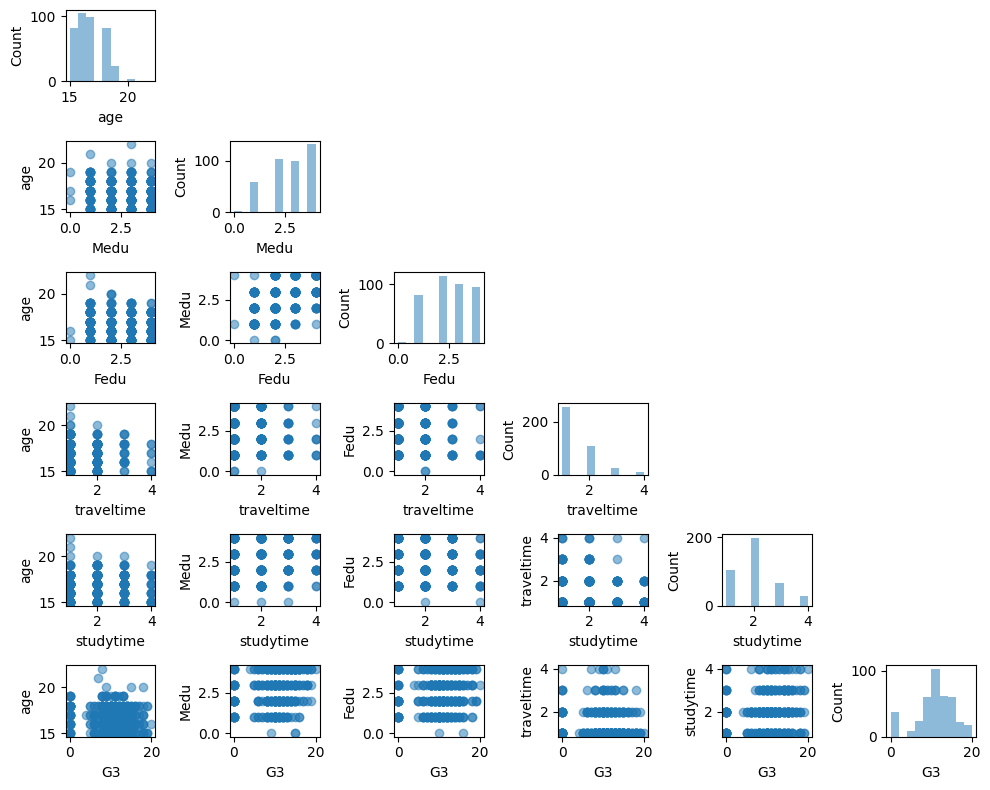

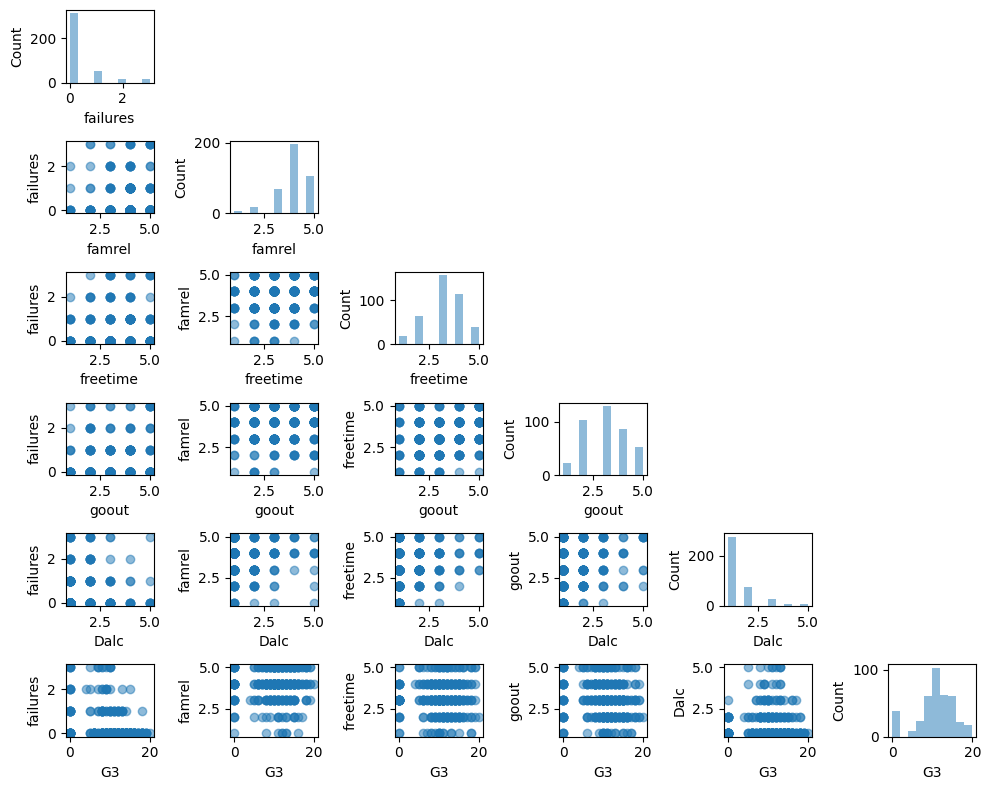

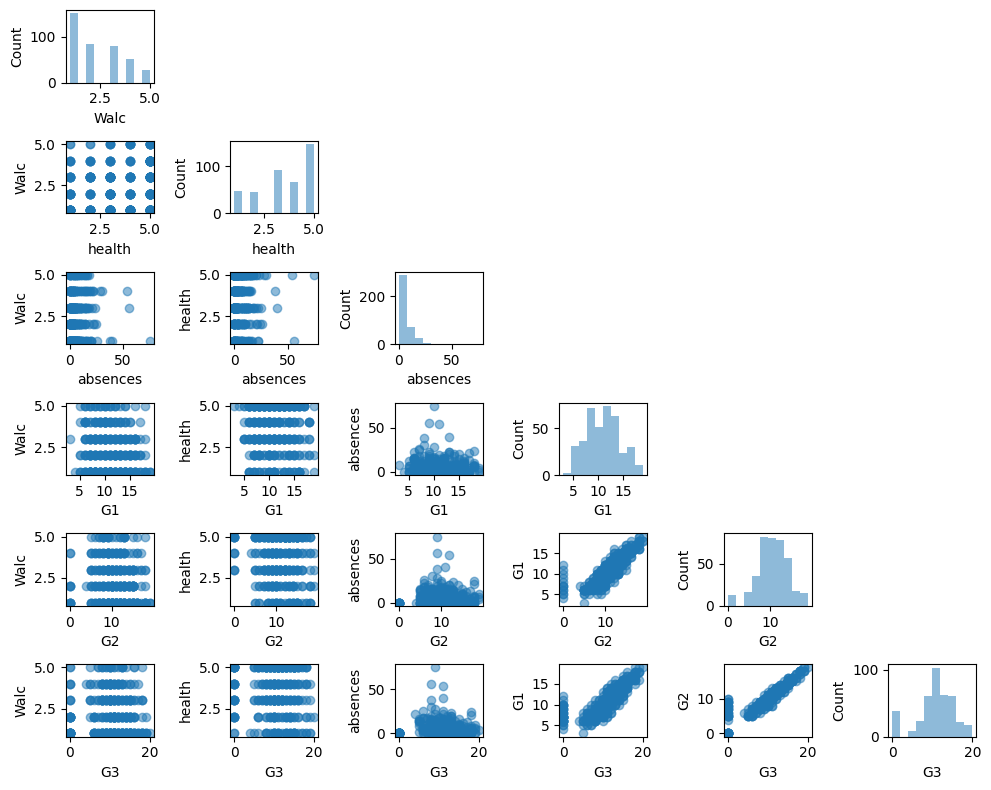

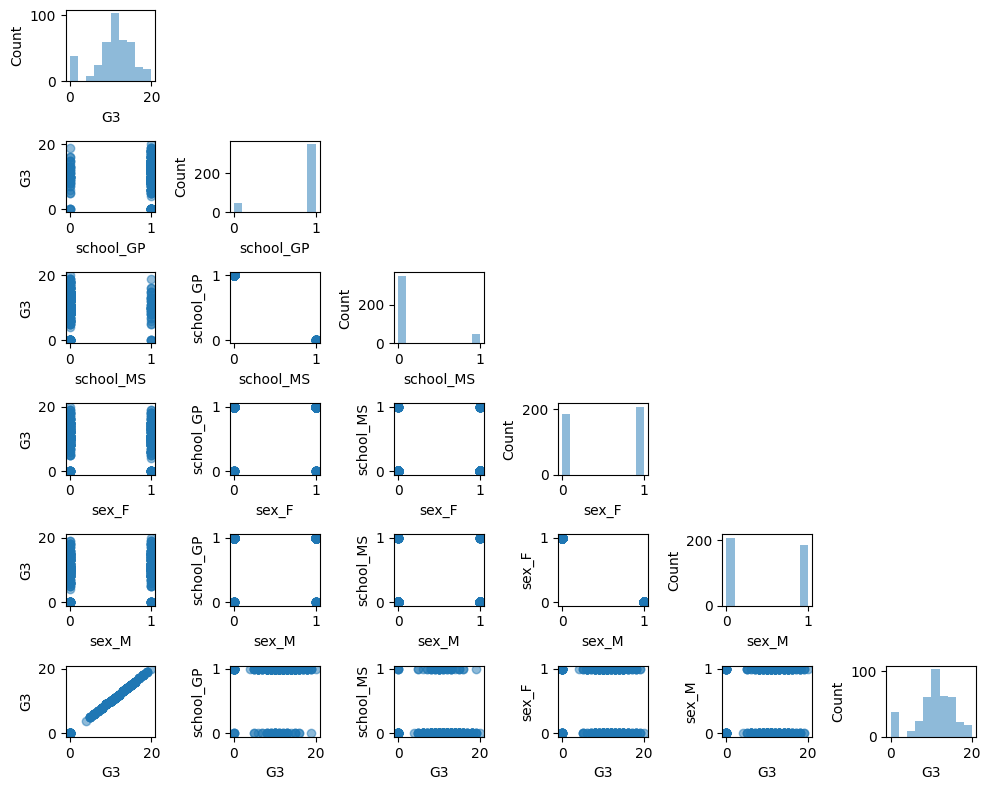

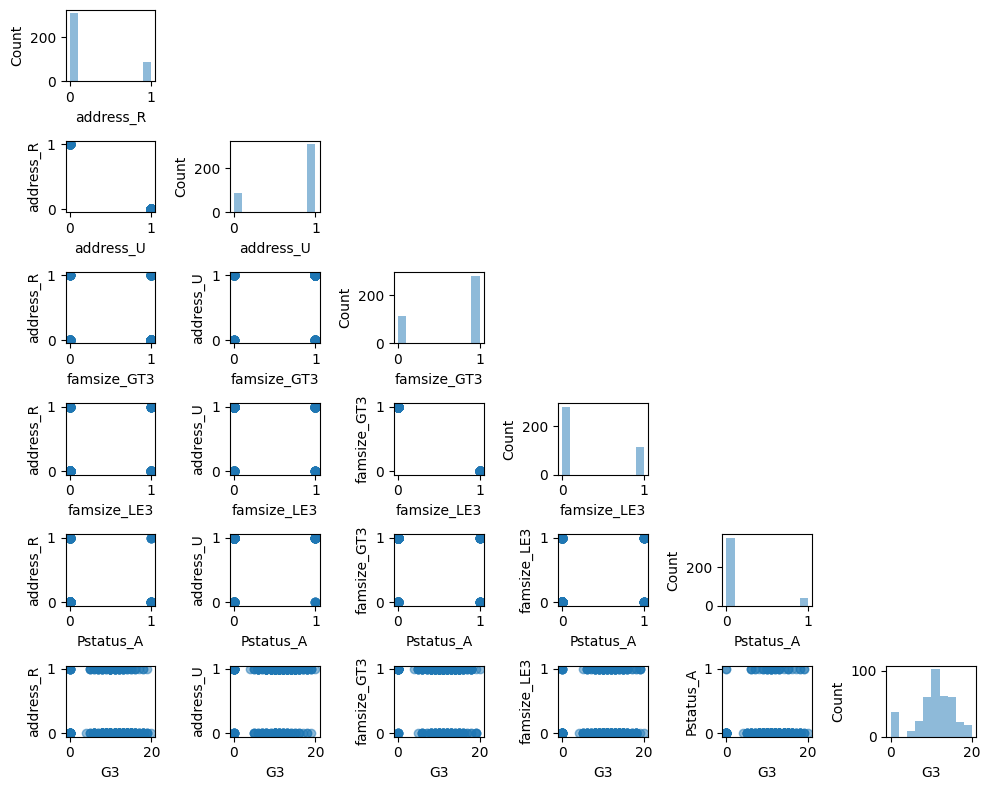

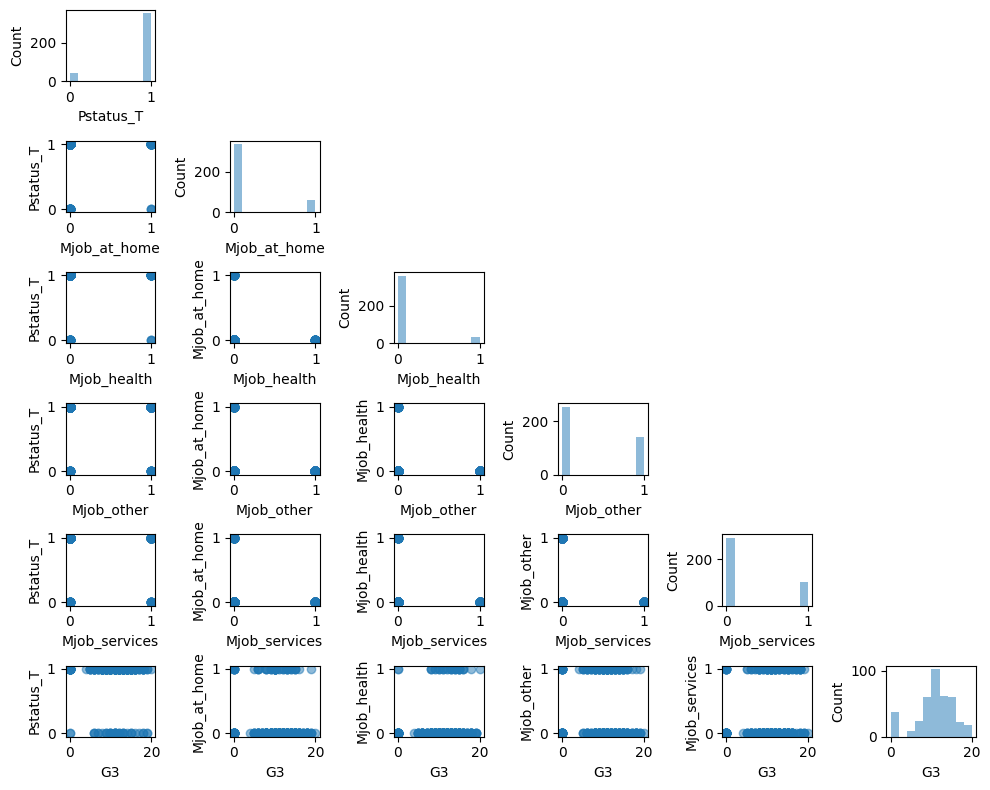

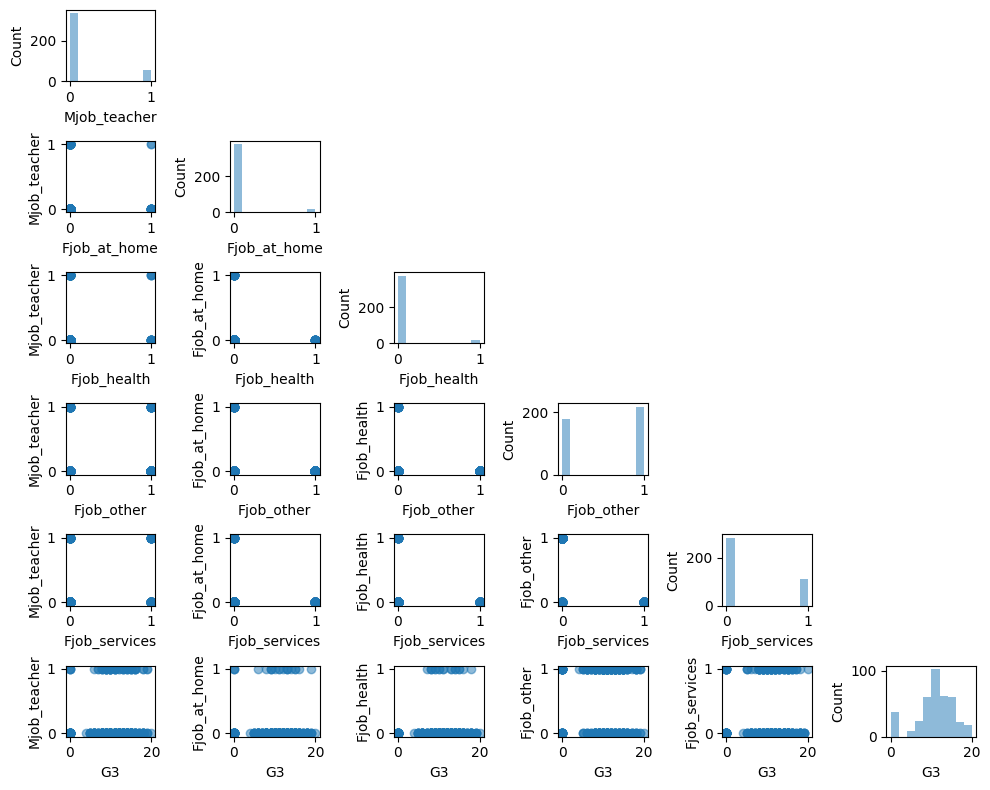

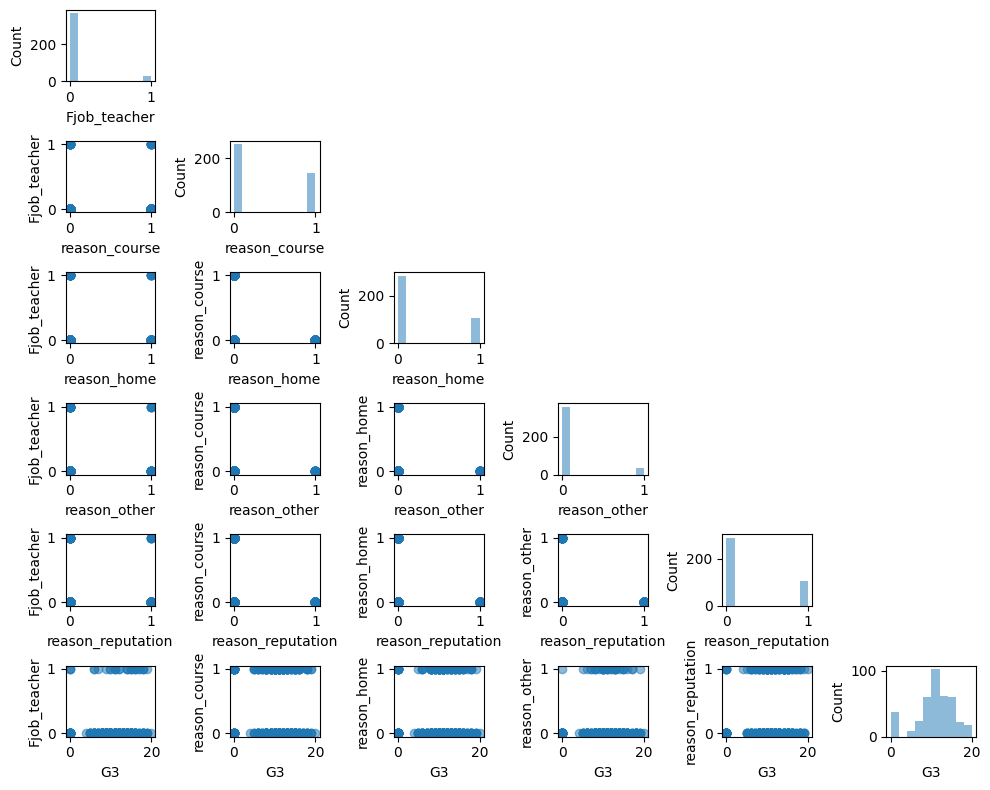

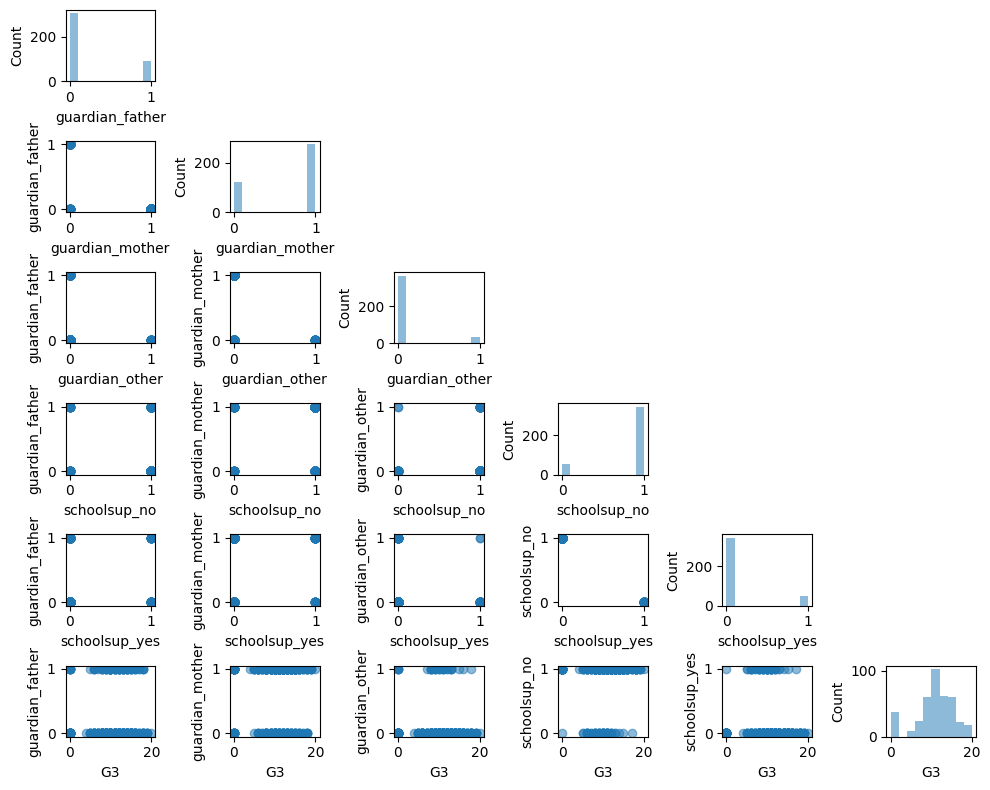

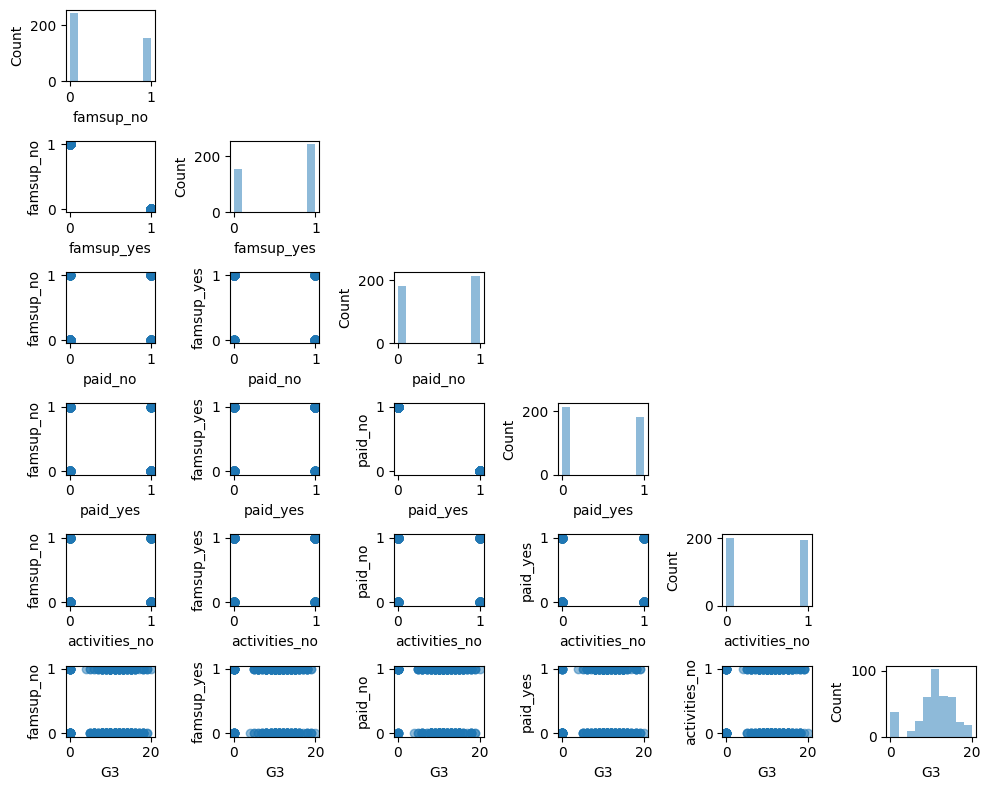

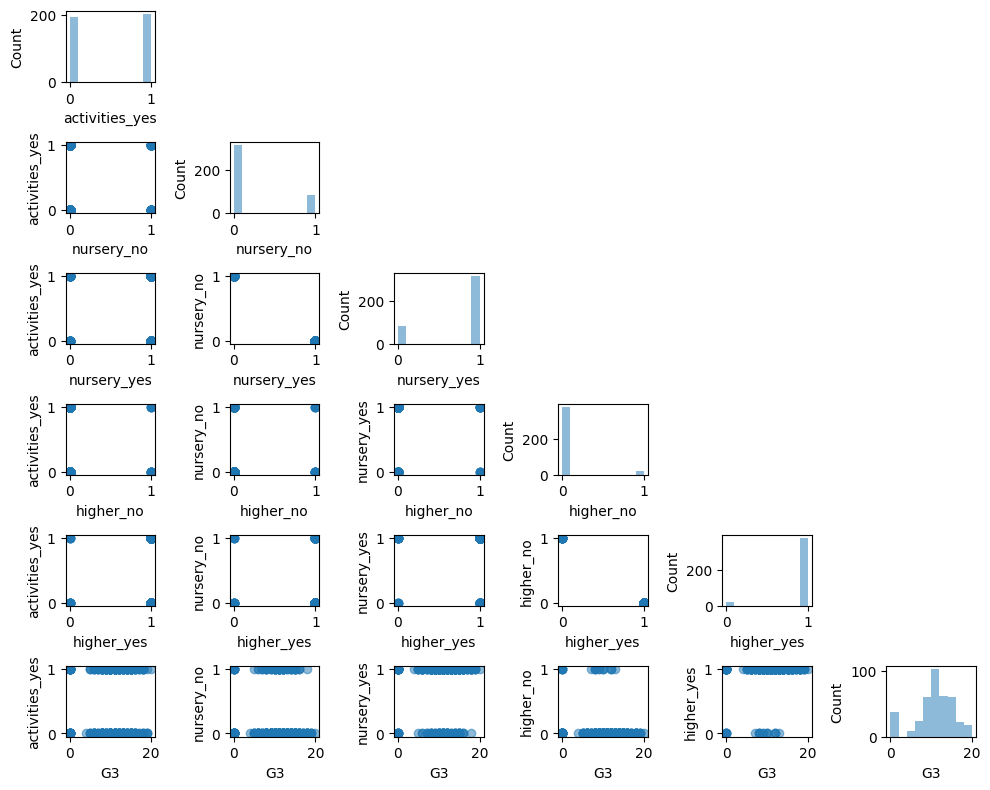

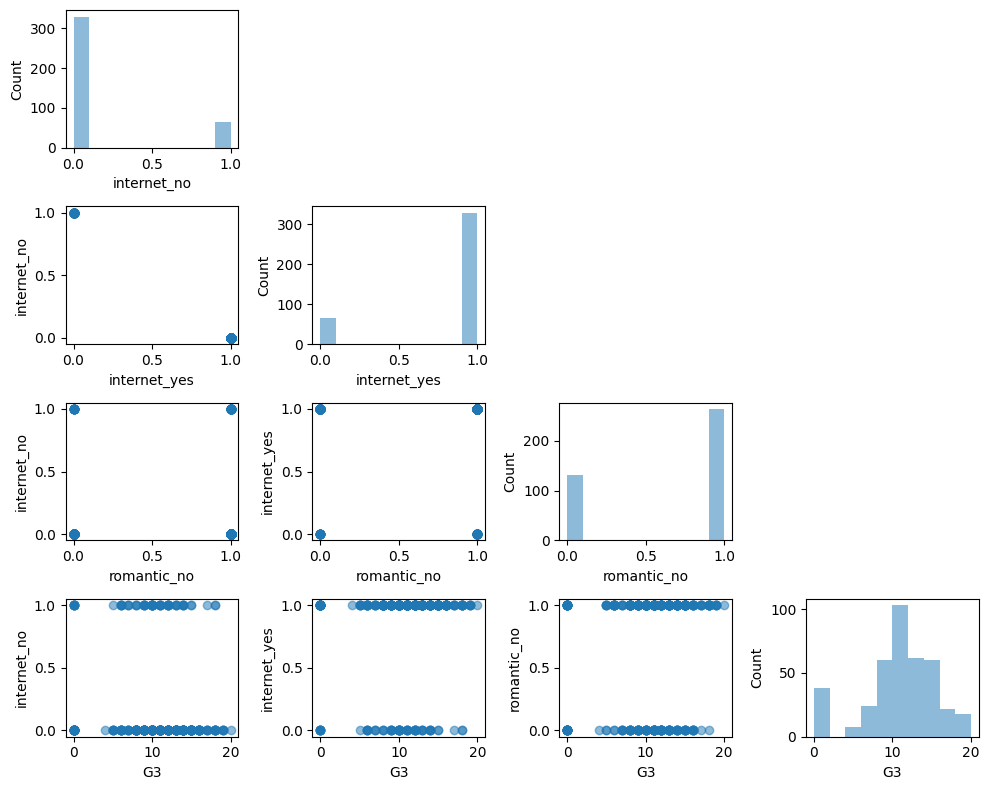

In [24]:
# Se explora la relación entre un conjunto específico de variables con la variable objetivo 'G3' por medio de gráficos de dispersión
for i in range(12):
  if i == 11:
    aux = columns[5*i:-1]
  else:
    aux = columns[5*i:5*(i+1)]
  aux = np.append(aux, 'G3')
  scatterplotmatrix(df_ohe[aux].values, figsize=(10, 8), names=df_ohe[aux].columns, alpha=0.5)
  plt.tight_layout()
  plt.show()

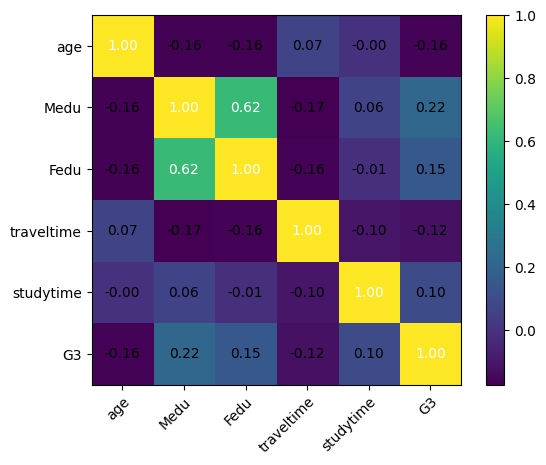

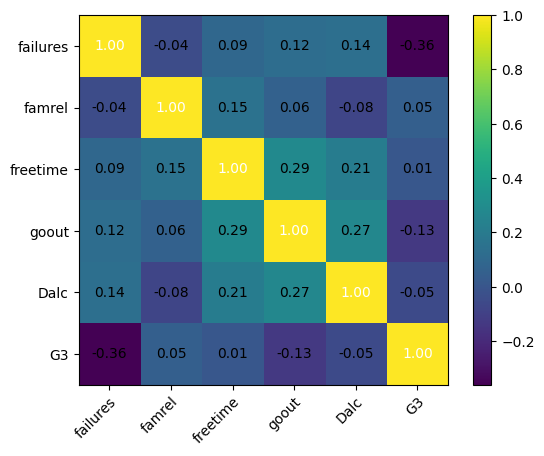

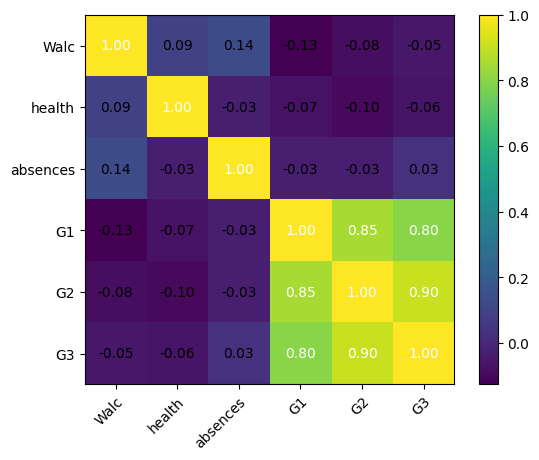

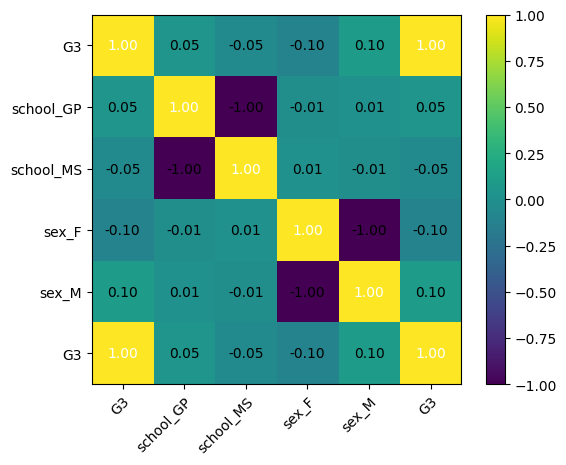

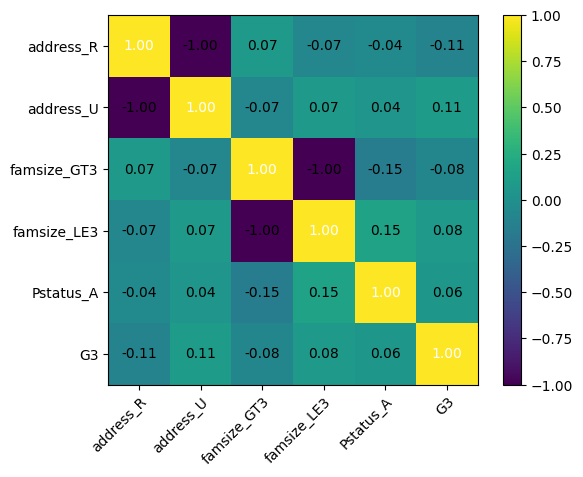

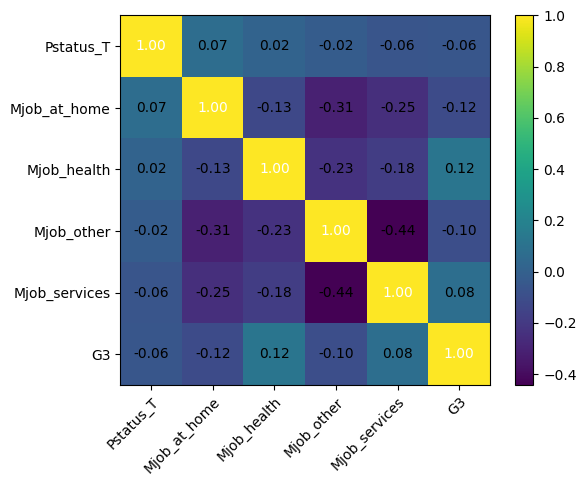

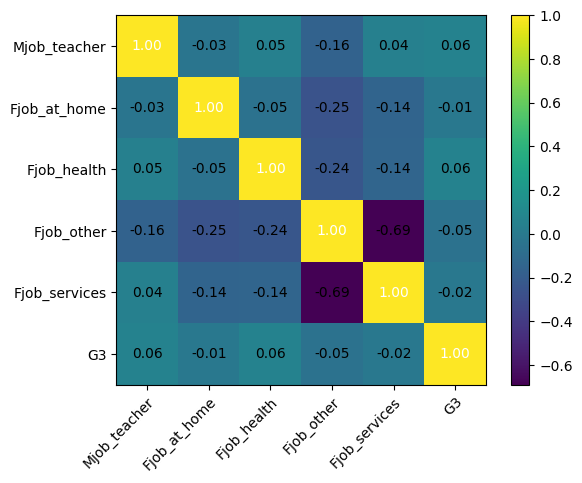

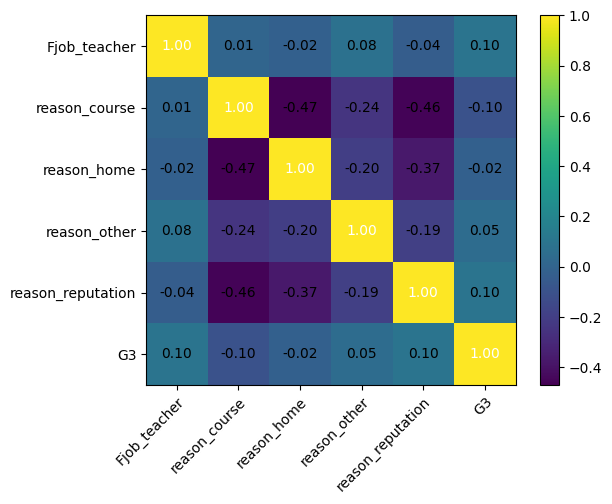

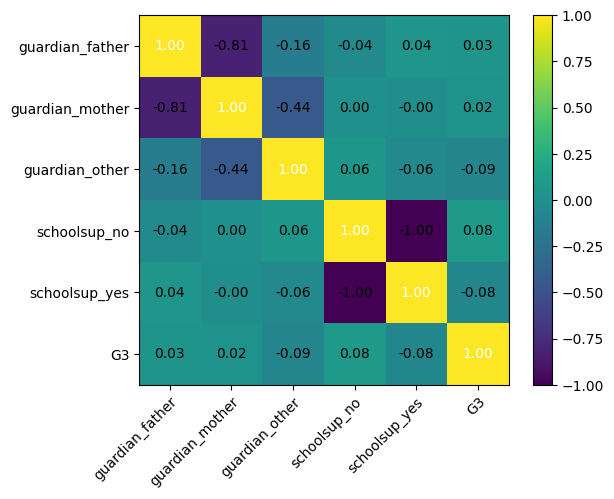

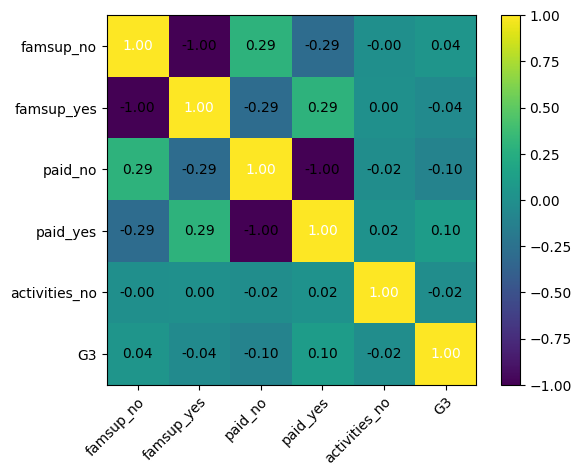

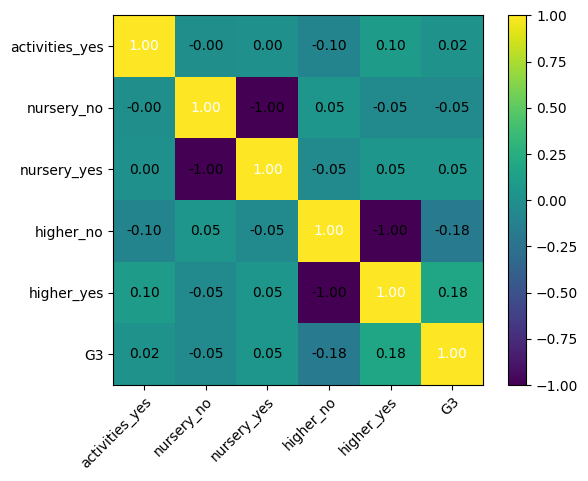

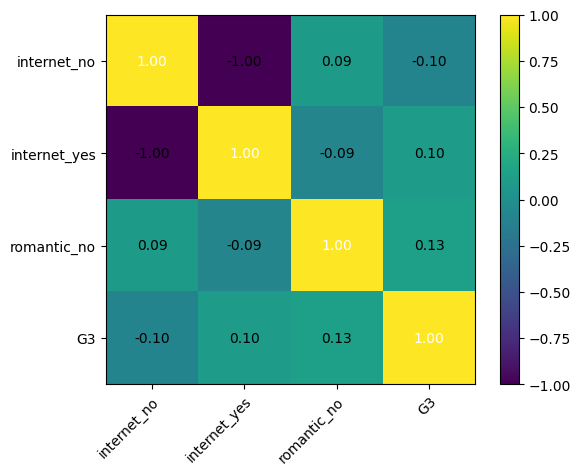

In [25]:
# Mapas de calor para identificar la correlación entre diferentes conjuntos de variables y la variable objetivo 'G3'

def plot_heatmap(a):
  cm = np.corrcoef(df_ohe[a].values.T)
  hm = heatmap(cm, row_names=a, column_names=df_ohe[a].columns)
  plt.show()

for i in range(12):
  if i == 11:
    aux = columns[5*i:-1]
  else:
    aux = columns[5*i:5*(i+1)]
  aux = np.append(aux, 'G3')
  plot_heatmap(aux)

# **División del DataFrame en conjuntos de entrenamiento y prueba**

In [26]:
X = df_ohe.loc[:,df_ohe.columns != "G3"]
y = df_ohe['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [27]:
scaler = MinMaxScaler()

# **Modelo de regresión lineal múltiple**

In [48]:
# Se crea una canalización con escalado y regresión lineal múltiple
pipe_lr = make_pipeline(scaler, LinearRegression())

# Crear un objeto KFold para la validación cruzada
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Realizar la validación cruzada y obtener los puntajes (scores)
scores = cross_val_score(pipe_lr, X_train, y_train, cv=kf, scoring='r2')

# Print the R^2 scores for each fold
for i, score in enumerate(scores):
    print(f'Fold {i + 1} R^2 Score: {score:.2f}')

# You can also calculate the mean and standard deviation of the scores
mean_score = scores.mean()
std_score = scores.std()

print(f'Mean R^2 Score: {mean_score:.2f}')
print(f'Standard Deviation of R^2 Scores: {std_score:.2f}')

Fold 1 R^2 Score: 0.83
Fold 2 R^2 Score: 0.80
Fold 3 R^2 Score: 0.77
Fold 4 R^2 Score: 0.83
Fold 5 R^2 Score: 0.65
Fold 6 R^2 Score: 0.85
Fold 7 R^2 Score: 0.88
Fold 8 R^2 Score: 0.84
Fold 9 R^2 Score: 0.74
Fold 10 R^2 Score: 0.85
Mean R^2 Score: 0.80
Standard Deviation of R^2 Scores: 0.06


In [41]:
# Se ajusta el modelo a los datos de entrenamiento
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

In [44]:
# Se estiman valores con el conjunto de prueba
y_predict = pipe_lr.predict(X_test)

print(f'MSE: {mean_absolute_error(y_test, y_predict):.2f}')

MSE: 1.65


In [45]:
print(f'MSE: {mean_squared_error(y_test, y_predict):.2f}')

MSE: 5.66


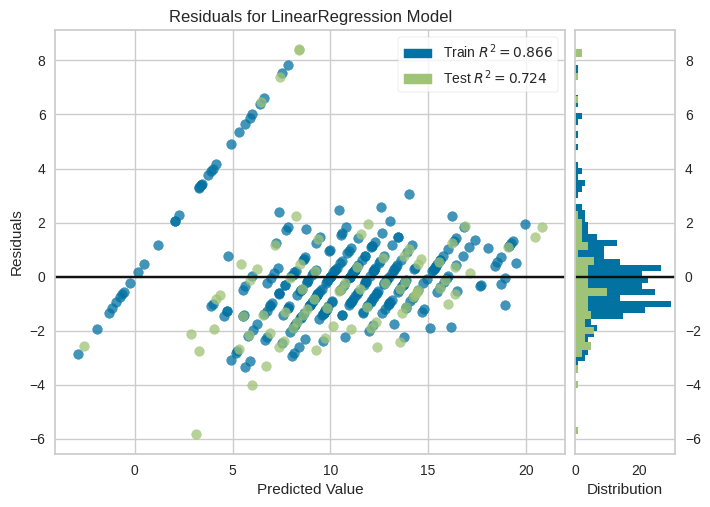

In [39]:
# Create the visualizer, fit, score, and show it
viz = residuals_plot(LinearRegression(), X_train, y_train, X_test, y_test)

In [42]:
# Se calcula el coeficiente de determinación R²
pipe_lr.score(X_test, y_test)

0.7241222637451111

# **Modelo de regresión polinomial** (no creo que se pueda usar)

In [ ]:
# Se crea una canalización con escalado y regresión polinómica
scaler = MinMaxScaler()
poly = PolynomialFeatures(degree=2)
regression = LinearRegression()

pipe = make_pipeline(scaler, poly, regression)

# Se ajusta el modelo a los datos de entrenamiento
pipe.fit(X_train, y_train)

In [ ]:
# pipe.score(X_test, y_test)

In [ ]:
y_pred = pipe.predict(X_test)

# Se calcula el coeficiente de determinación R²
r2 = r2_score(y_test, y_pred)
print(r2)

# **Modelo de regresión con Random Forest Regression**

In [ ]:
# Se creae una canalización con escalado y modelo de Random Forest
scaler = MinMaxScaler()
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

pipe = make_pipeline(scaler, random_forest)

# Se ajusta el modelo a los datos de entrenamiento
pipe.fit(X_train, y_train)

In [ ]:
# Predicciones en el conjunto de prueba y evaluación del rendimiento del modelo
y_pred = pipe.predict(X_test)

# Se calcula el coeficiente de determinación R²
r2 = r2_score(y_test, y_pred)
print(r2)

# **Modelo de regresión utilizando Support Vector Regression(SVR) con un kernel RBF**

In [ ]:
# Se crea una canalización con escalado y modelo de SVR con kernel RBF
scaler = MinMaxScaler()
svr = SVR(kernel='rbf')  # El kernel RBF es el kernel por defecto

pipe = make_pipeline(scaler, svr)

# Se ajusta el modelo a los datos de entrenamiento
pipe.fit(X_train, y_train)

In [ ]:
# Predicciones en el conjunto de prueba y evaluación del rendimiento del modelo
y_pred = pipe.predict(X_test)

# Se calcula el coeficiente de determinación R²
r2 = r2_score(y_test, y_pred)
print(r2)

# **Modelo de regresión utilizando Redes Neuronales Artificiales(ANN)**

In [ ]:
# Se escalan las características
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Se crea y entrena el modelo
ann = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

ann.fit(X_train_scaled, y_train)

In [ ]:
# Predicciones en el conjunto de prueba y evaluación del rendimiento del modelo
y_pred = ann.predict(X_test_scaled)

# Se calcula el coeficiente de determinación R²
r2 = r2_score(y_test, y_pred)
print(r2)